In [1]:
import mne
import numpy as np
from pymatreader import read_mat
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import iqr
import seaborn as sns

In [4]:
def compute_rms(signal,axis=None):
    return np.sqrt(np.mean(signal**2,axis=axis))

In [5]:
def compute_snr(signal, noise, axis=None):
    signal = compute_rms(signal, axis) 
    noise = compute_rms(noise, axis)
    return 10*np.log10(signal/noise)

In [26]:
import warnings
from mne import create_info
from mne.io import RawArray
from mne.viz.topomap import _add_colorbar
from mne.viz import plot_topomap
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_values_topomap(value_dict, montage, axes, colorbar=True, cmap='PiYG',
                        vmin=None, vmax=None, names=None, image_interp='linear', side_cb="right",
                        sensors=True, show_names=True, format='%2.1e', cbar_title='', **kwargs):
    if names is None:
        names = montage.ch_names

    info = create_info(names, sfreq=256, ch_types="eeg")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        RawArray(np.zeros((len(names), 1)), info, copy=None, verbose=False).set_montage(montage)

    im = plot_topomap([value_dict[ch] for ch in names], pos=info, show=False, image_interp=image_interp,
                      sensors=sensors, res=64, axes=axes, names=None, cmap=cmap, vlim=(vmin,vmax),**kwargs)

    if colorbar:
        try:
            cbar, cax = _add_colorbar(axes, im[0], cmap, pad=.05,
                                      format=format, side=side_cb)
            axes.cbar = cbar
            cbar.ax.tick_params(labelsize=10)
            cax.set_ylabel(cbar_title)

        except TypeError:
            pass

    return im

In [7]:
def plot_topo(means_stat, stat, **kwargs):
    dict_topomap = dict(zip(means_stat['channel'], means_stat[stat]))
    channel_names = list(means_stat['channel'])
    montage = mne.channels.make_standard_montage("GSN-HydroCel-129")
    fig, axes = plt.subplots(1,1,figsize=(15,5))
    plot_values_topomap(dict_topomap, montage, axes, names=channel_names, **kwargs)

### Code to create the dataframe 'df_snr.csv'

In [8]:
ab_ica_pt_selection = pd.read_excel('/Users/lina_01/Desktop/ab_ica/AB_ICA_pt_table.xlsx')

In [9]:
ab_ica_pt_selection.rename(columns={'Unnamed: 0':'pts'}, inplace=True)

In [10]:
pts = list(ab_ica_pt_selection['pts'])
df_snr = []
path = 'C:/Users/dsrish/Desktop/fieldtrip-20220208'
for kind, seg_type in product(['AB', 'ICA'], ['clean', 'saccade']):
    for pt in pts:
        rest_raw_processed = mne.io.read_raw_fif(f'{path}/{pt}_rest_raw_processed.fif')
        channels = rest_raw_processed.ch_names
        for chan in channels:
            if kind=='AB':
                AB_mat_outdata = read_mat(f'{path}/{pt}_AB_outdata.mat')
                AB_mat_outdata = AB_mat_outdata['datatosave_out']['OutData']
                rest_raw_corrected = mne.io.RawArray(AB_mat_outdata, rest_raw_processed.info)
            else:
                rest_raw_corrected = mne.io.read_raw_fif(f'{path}/{pt}_rest_raw_ica.fif')

            annot_file = f"C:/Users/dsrish/Desktop/ds_msc_project/manual_annot_AB_ICA_{pt}.csv"
            annotations = mne.read_annotations(annot_file)
            times = {}
            seg_no = 0
            for annot in annotations:
                times['onset'] = np.array([annot['onset'] for annot in annotations 
                                           if annot['description']==f'{seg_type}'])
                times['duration'] = np.array([annot['duration'] for annot in annotations 
                                              if annot['description']==f'{seg_type}'])
                times['offset'] = times['onset'] + times['duration']
            for time in list(range(0, len(times['onset']))):
                tmin = times['onset'][time]
                tmax = times['offset'][time]
                signal_original = rest_raw_processed.get_data(picks=chan, tmin=tmin, tmax=tmax)
                signal_corrected = rest_raw_corrected.get_data(picks=chan, tmin=tmin, tmax=tmax)
                noise = signal_original - signal_corrected
                snr = [compute_snr(signal_corrected, noise, axis=None)]
                df = pd.DataFrame(snr)
                seg_no = seg_no + 1
                df['seg_no'] = seg_no
                df['subject'] = pt
                df['kind'] = kind
                df['seg_type'] = seg_type
                df['channel'] = chan
                df['tmin'] = tmin
                df['tmax'] = tmax
                df_snr.append(df)

KeyError: 'pts'

In [11]:
df_snr = pd.concat(df_snr)
df_snr.rename(columns = {0:"snr"}, inplace=True)
np.any(np.isinf(df_snr.snr))

False

In [11]:
df_snr = pd.read_csv('/Users/lina_01/Desktop/ab_ica/df_snr.csv')

## Figure 9

In [20]:
vmin = df_snr_saccade['snr'].min()

In [21]:
vmax = df_snr_saccade['snr'].max()

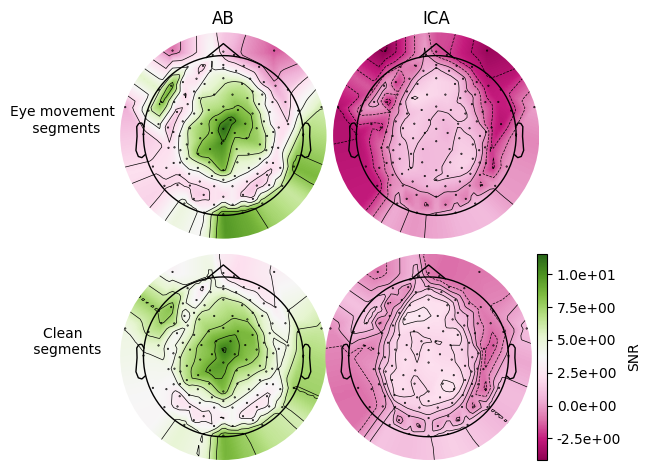

In [30]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2)

df_snr_saccade = df_snr.loc[df_snr['seg_type']=='saccade']
df_snr_saccade = df_snr_saccade.groupby(['channel', 'kind']).mean('snr').reset_index()

df_snr_saccade_ab = df_snr_saccade.loc[df_snr_saccade['kind']=='AB']
montage = mne.channels.make_standard_montage("GSN-HydroCel-129")
dict_topomap = dict(zip(df_snr_saccade_ab['channel'], df_snr_saccade_ab['snr']))
channel_names = list(df_snr_saccade_ab.channel)
plot_values_topomap(dict_topomap, montage,ax0,colorbar=False,vmin=vmin,vmax=vmax)
ax0.set_title('AB')
ax0.set_ylabel('Eye movement \n segments', labelpad=40, rotation = 'horizontal',fontsize=10, loc='center')

df_snr_saccade_ica = df_snr_saccade.loc[df_snr_saccade['kind']=='ICA']
montage = mne.channels.make_standard_montage("GSN-HydroCel-129")
dict_topomap = dict(zip(df_snr_saccade_ica['channel'], df_snr_saccade_ica['snr']))
channel_names = list(df_snr_saccade_ica.channel)
plot_values_topomap(dict_topomap, montage, ax1,colorbar=False,vmin=vmin,vmax=vmax)
ax1.set_title('ICA')

df_snr_clean = df_snr.loc[df_snr['seg_type']=='clean']
df_snr_clean = df_snr_clean.groupby(['channel', 'kind']).mean('snr').reset_index()

df_snr_clean_ab = df_snr_clean.loc[df_snr_clean['kind']=='AB']
montage = mne.channels.make_standard_montage("GSN-HydroCel-129")
dict_topomap = dict(zip(df_snr_clean_ab['channel'], df_snr_clean_ab['snr']))
channel_names = list(df_snr_clean_ab.channel)
plot_values_topomap(dict_topomap, montage, ax2, colorbar=False,vmin=vmin,vmax=vmax)
ax2.set_ylabel('Clean \n segments', labelpad=40, rotation = 'horizontal',fontsize=10, loc='center')

df_snr_clean_ica = df_snr_clean.loc[df_snr_clean['kind']=='ICA']
montage = mne.channels.make_standard_montage("GSN-HydroCel-129")
dict_topomap = dict(zip(df_snr_clean_ica['channel'], df_snr_clean_ica['snr']))
channel_names = list(df_snr_clean_ica.channel)
plot_values_topomap(dict_topomap, montage, ax3, colorbar=True,cbar_title='SNR',vmin=vmin,vmax=vmax)

fig.tight_layout()
plt.savefig('snr.png')

## Statistical analysis

In [12]:
montage = mne.channels.make_standard_montage(kind='GSN-HydroCel-129')
info = mne.create_info(montage.ch_names, sfreq=500, ch_types='eeg')
raw = mne.io.RawArray(np.zeros([129,1]), info).set_montage(montage)

Creating RawArray with float64 data, n_channels=129, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


In [13]:
adj_matrix = mne.channels.find_ch_adjacency(raw.info, ch_type='eeg')[0]

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 129


#### averaging snr across segments

In [14]:
df_snr_pt_avg = df_snr.groupby(['subject', 'channel', 'seg_type', 'kind']).mean().reset_index()

In [15]:
df_snr_pt_avg_saccade = df_snr_pt_avg.loc[df_snr_pt_avg['seg_type'] == 'saccade']
df_snr_pt_avg_saccade_ica = df_snr_pt_avg_saccade.loc[df_snr_pt_avg_saccade['kind'] == 'ICA']
df_snr_pt_avg_saccade_ab = df_snr_pt_avg_saccade.loc[df_snr_pt_avg_saccade['kind']=='AB']

snr_saccade_array_ica = df_snr_pt_avg_saccade_ica[['snr', 'subject', 'channel']]
snr_saccade_array_ica = np.array(snr_saccade_array_ica.pivot_table(index='subject', columns='channel', values='snr'))

snr_saccade_array_ab = df_snr_pt_avg_saccade_ab[['snr', 'subject', 'channel']]
snr_saccade_array_ab = np.array(snr_saccade_array_ab.pivot_table(index='subject', columns='channel', values='snr'))

In [16]:
X_saccade = np.array([snr_saccade_array_ab, snr_saccade_array_ica])

In [17]:
def wilcox_stat_fun(x, y, axis=0):
    return 1/stats.wilcoxon(x,y,axis=axis)[0]

In [18]:
w, clusters, clusters_pv, h0 = mne.stats.permutation_cluster_test(X_saccade, threshold=1/434, n_permutations=1000, 
                                                                  stat_fun=wilcox_stat_fun,
                                                                  adjacency=adj_matrix)

stat_fun(H1): min=0.002907 max=inf
Running initial clustering …


/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1730/3453851328.py:2: RuntimeWarning: divide by zero encountered in divide
  return 1/stats.wilcoxon(x,y,axis=axis)[0]


Found 1 cluster


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [21]:
dfs = []
for i in list(range(len(clusters))):
    clusters_array = np.array(clusters[i])
    df = pd.DataFrame(clusters_array).T
    df['Cluster'] = i
    df = df.rename(columns= {0:'Channel',1:'Scale'}) 
    dfs.append(df)

In [27]:
heatmap_df = pd.concat(dfs)
heatmap_df = pd.pivot_table(heatmap_df, columns='Channel')

<Axes: xlabel='Channel'>

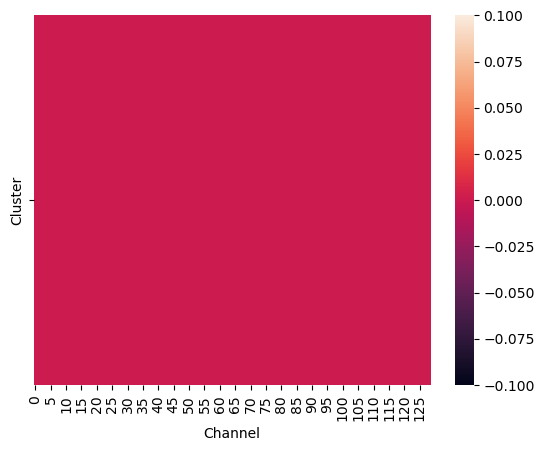

In [28]:
sns.heatmap(heatmap_df)

<Axes: xlabel='channel', ylabel='snr'>

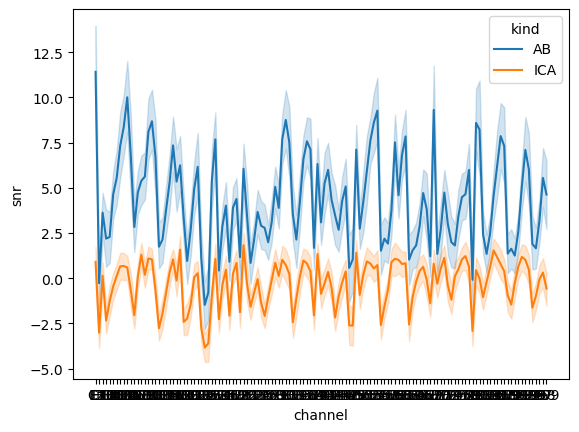

In [39]:
sns.lineplot(x='channel', y='snr', hue='kind', data=df_snr_pt_avg[df_snr_pt_avg['seg_type']=='saccade'])

In [29]:
df_snr_pt_avg_clean = df_snr_pt_avg.loc[df_snr_pt_avg['seg_type'] == 'clean']
df_snr_pt_avg_clean_ica = df_snr_pt_avg_clean.loc[df_snr_pt_avg_clean['kind'] == 'ICA']
df_snr_pt_avg_clean_ab = df_snr_pt_avg_clean.loc[df_snr_pt_avg_clean['kind']=='AB']

In [30]:
snr_clean_array_ab = df_snr_pt_avg_clean_ab[['snr', 'subject', 'channel']]
snr_clean_array_ab = np.array(snr_clean_array_ab.pivot_table(index='subject', columns='channel', values='snr'))

In [31]:
snr_clean_array_ica = df_snr_pt_avg_clean_ica[['snr', 'subject', 'channel']]
snr_clean_array_ica = np.array(snr_clean_array_ica.pivot_table(index='subject', columns='channel', values='snr'))
snr_clean_array_ica = np.array(snr_clean_array_ica)

In [32]:
X_clean = np.array([snr_clean_array_ab, snr_clean_array_ica])

In [33]:
w, clusters, clusters_pv, h0 = mne.stats.permutation_cluster_test(X_clean, threshold=1/434, n_permutations=1000, 
                                                                  stat_fun=wilcox_stat_fun,
                                                                  adjacency=adj_matrix)

stat_fun(H1): min=0.003279 max=inf
Running initial clustering …
Found 1 cluster


/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1150/3453851328.py:2: RuntimeWarning: divide by zero encountered in divide
  return 1/stats.wilcoxon(x,y,axis=axis)[0]


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [36]:
dfs = []
for i in list(range(len(clusters))):
    clusters_array = np.array(clusters[i])
    df = pd.DataFrame(clusters_array).T
    df['Cluster'] = i
    df = df.rename(columns= {0:'Channel',1:'Scale'}) 
    dfs.append(df)

In [37]:
heatmap_df = pd.concat(dfs)
heatmap_df = pd.pivot_table(heatmap_df, columns='Channel')

<Axes: xlabel='Channel'>

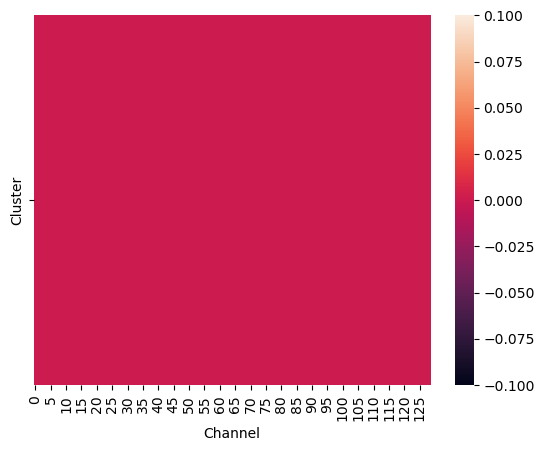

In [38]:
sns.heatmap(heatmap_df)